In [26]:
import numpy as np
import cv2
import copy
import matplotlib.pyplot as plt
%matplotlib inline

from directions import DirLine, Direct, DirectList
from process_hist import HistAvg, HistAvgMulti
from dispertion_coeff import DispCoeff, DispCoeffMulty
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(713, 504)


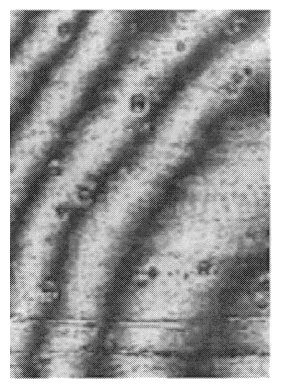

In [114]:
img_path = '3.jpg'

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
print(img.shape)

plt.imshow(img, cmap ='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

In [120]:
class Circle:
    
    def __init__(self, i: int, j: int, r: int, M: int) -> None:
        self.c = np.array([i, j])
        self.r = r
        self.M = M

        self.angles = [2*np.pi*i/self.M for i in range(self.M)]
        self.points = []
        self.calc_points_()
        
        self.intencity = []

    def calc_points_(self):
        self.points = [self.c + np.array([self.r*np.cos(alpha), self.r*np.sin(alpha)]).astype(np.int32) for alpha in self.angles]

    def project_intencity(self, img) -> np.ndarray:
        self.intencity = np.array([img[*p] for p in self.points])

        return self.intencity

    def calcA(self) -> float:
        return 0.5*(np.max(self.intencity) - np.min(self.intencity))

    def calcD(self) -> float:
        D = 0.5*np.sum(np.abs(self.intencity[1:]-self.intencity[:-1]))
        return D

    def update_r(self, r):
        self.r = r
        self.calc_points_()
        self.intencity = []

    def draw(self, img):
        img_out = copy.deepcopy(img)

        for p in self.points:
            #print(point, p, img_in[*p], sep=": ")
            if img[*p] < 150:
                img_out[*p] = 255
            else:
                img_out[*p] = 0

        return img_out


In [114]:
def draw_circle(img_in: np.ndarray, c: Circle) -> np.ndarray:
    img_out = copy.deepcopy(img_in)
         
    for p in c.points:
            #print(point, p, img_in[*p], sep=": ")
        try:
            pint = img_in[*p]
        except IndexError:
            pass
        else:
            if pint < 150:
                img_out[*p] = 255
            else:
                img_out[*p] = 0

    return img_out

In [110]:
def draw_circles(img_in: np.ndarray, dx: int, dy: int, r:int, M: int) -> np.ndarray:
    img_out = copy.deepcopy(img_in)
    
    nx = (img_in.shape[0])//dx - 1 
    ny = (img_in.shape[1])//dy - 1

    points = [[x, y] for x in [d*(i+1) for i in range(nx)] for y in [d*(i+1) for i in range(ny)]]
    #print(points)
    #print(*points[1])

    for point in points:
        c = Circle(*point, r, M)
        for p in c.points:
            #print(point, p, img_in[*p], sep=": ")
            if img_in[*p] < 150:
                img_out[*p] = 255
            else:
                img_out[*p] = 0

    return img_out
    

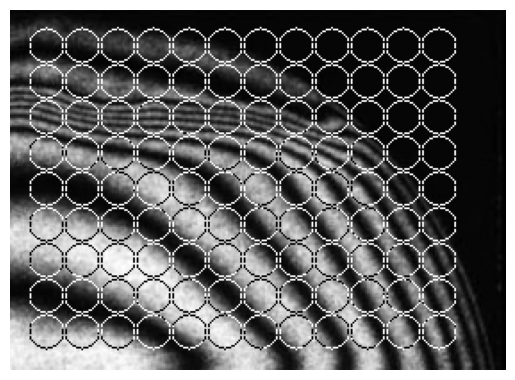

In [107]:
img_c = draw_circles(img, 20,10,50)

plt.imshow(img_c, cmap ='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

# lower we implement an algoritm for iterative smoothing of an image
1. firstly, we extract lines along given direction from image
2. secondly, we create a linear weight function g(x)
3. thirdly, we compute a modified histogram, which is calculated as
   \begin{equation}
   h(\xi_j) = \sum_{i=-L/2}^{L/2} {g(x_i)\delta(\xi(g(x_i)-\xi_j))}
   \end{equation}
   This histogramm accounts for decreasing with distance connection betweeen intencities of the middle point and points $x_i$ of the interval. Function $g(x)$ provides weights to contributions of points to the histogram.
4. next, we choose sample length $L$, starting from $n = 0$ we move interval $[x_n: x_{n+L}]$ along extracted line. For each n histogram is calculated and intencity of the central point $x_c$, where $c = n+L//2$ is restored from said histogram according to expression:
   \begin{equation}
   \xi_{aver}(x_c) = \sum_{i=0}^{255} {\xi_i h(\xi_i)}
   \end{equation}

In [90]:
alpha = np.pi/3
x0 = 20

dir_p = DirLine(angle=alpha, x0=x0)

line, points = dir_p.get_line(img)

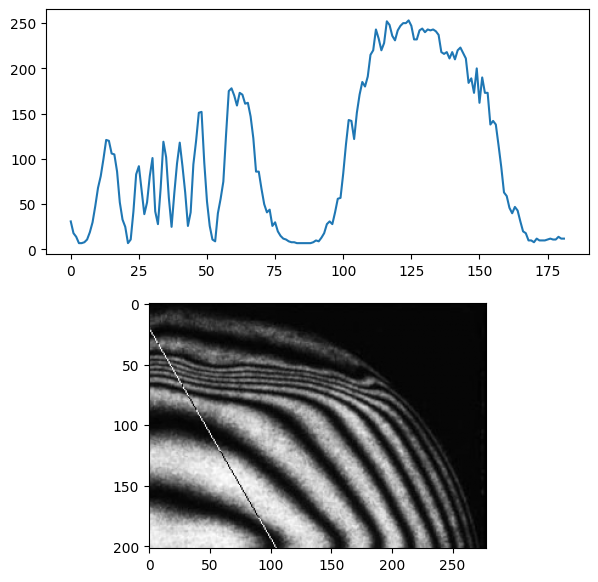

In [91]:
img_line = dir_p.draw_points(img)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))
ax1.plot(line)

ax2.imshow(img_line, cmap='gray', vmin=0, vmax=255)
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


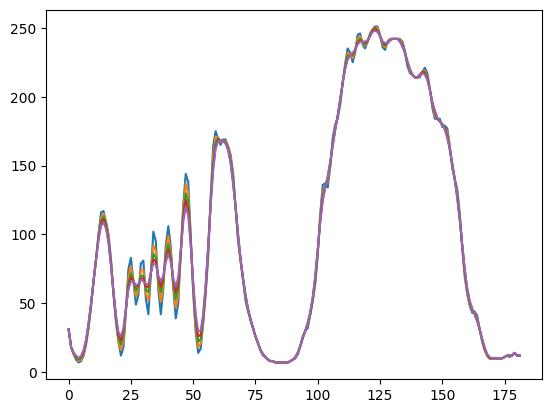

In [83]:
L = 5
new_line = line
my_avg_pr = HistAvg(L)

for _ in range(5):
    new_line = my_avg_pr.process(new_line)

    #plt.figure()
    plt.plot(new_line)

## We have implemented Gurov's filtering method to one dimentional signal, now it is nesassary to extend it to 2D-signals (images)

### At last, the length of averaging interval for histogram generation must be calculated interactively, depending on the data analysed

To achieve it, the following method is proposed:

~~Note, that $L$ must be minimal if local fringe pattern is perpendiculat to line direction and $L$ can be larger, if the line lyes anong the fringe.~~
To use the same $L$ along all directions and points $p_{i,j}$ with nither loosing small details of the signal, nor interpreting noize as usefull signal, we calculate $\xi (p_{i,j})$ as weighted averaged across directions of lines.
Let's considere a point on an image and lines, going through this point:
the direction of line $l$, along which gradient of intencity is the lowest, can be considered the closest to fringe direction

1. For now, instead of gradient, we can use dispertion, given by:
   \begin{equation}
   D(x_i) \equiv D(i,j,l) = \sum_{j=i-L//2}^{i+L//2} {(\xi (x_j) - \langle \xi \rangle)^2}
   \end{equation}
2. Direction $l$, which priduces the smallest dispersion is considered as direction along the fridge.
3. The dispertions $D(i,j,l)$ are averaged in 2D area $[i-di:i+di] \times [j-dj:j+dj]$ for all $l$, the result is assigned to $C(i,j,l)$.
4. The finel intensity at point $p(i,j)$ is calculated as follows:
   \begin{equation}
   \xi (i,j) = \sum_{l} {\xi (i,j,l) C(i,j,l^{trans})}/ \sum_{l} {C(i,j,l^{trans})}
   \end{equation}

In [98]:
print(np.max(img))

255


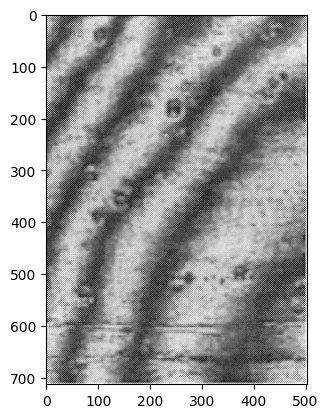

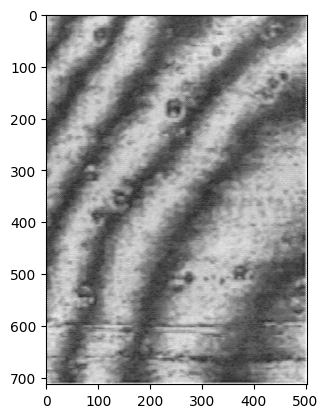

In [115]:
alpha = 0

direction = Direct(alpha)
direction.img_to_direction(img)
img_from_dir = direction.lines_to_img()

plt.imshow(img_from_dir, cmap='gray', vmin=0, vmax=255)
plt.show()


#hist_avg = HistAvg(L=7)

#new_direction = Direct(alpha, img_shape=img.shape)
#new_direction.points = direction.points
#new_direction.lines = hist_avg.process(direction.lines)

#new_img_from_dir = new_direction.lines_to_img()
direction.process(L=7)

new_img_from_dir = direction.lines_to_img()

plt.imshow(new_img_from_dir, cmap='gray', vmin=0, vmax=255)
plt.show()

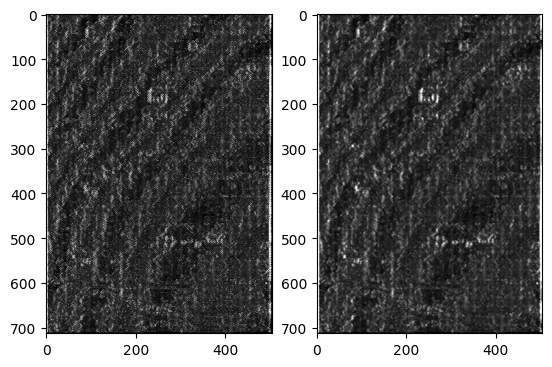

In [116]:
disp = DispCoeff(L=3, M=3)

img_d = disp.line_list_dispertion(direction)
img_c = disp.avg_line_list_dispertion(img_d)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(img_d, cmap='gray', vmin=0, vmax=255)

plt.subplot(1,2,2)
plt.imshow(img_c, cmap='gray', vmin=0, vmax=255)
plt.show()


In [136]:
angles = [0, -np.pi/4, np.pi/4, np.pi/2]

directions = DirectList(angles)
directions.img_to_directions(img)


#directions.process(L=11)

directions.lines_to_img()
#directions.show_imgs()

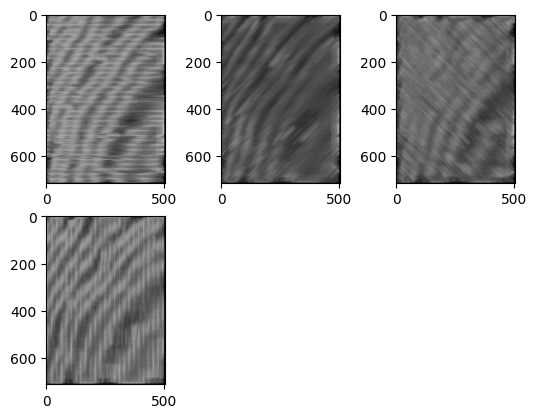

In [137]:
my_disp = DispCoeffMulty(L=70,M=10)
my_disp.line_list_dispertion(directions)
my_disp.avg_line_list_dispertion()

plt.figure()

for i, c_img in enumerate(my_disp.d_arr_list):
    plt.subplot(2,3,i+1)
    plt.imshow(c_img/np.max(c_img)*255, cmap='gray')#, vmin=0, vmax=255)
plt.show()

In [138]:
np.array(my_disp.c_arr_list)[:,100,100]


array([7852.29611982, 4473.4538901 , 5483.9429518 , 7140.54534021])

In [156]:
def smooth_fringes(directions, dispersions):
    c_arr_list = np.array(dispersions.c_arr_list)
    img_dir_list = np.array(directions.dir_imgs)
    img_finale = (np.sum(c_arr_list[::-1]*img_dir_list, axis=0)/np.sum(c_arr_list, axis=0)).astype(int)

    return img_finale


In [ ]:
directions.process(L=50)
directions.lines_to_img()
img_fin = smooth_fringes(directions, my_disp)

plt.figure()
plt.imshow(img_fin, cmap='gray', vmin=0, vmax=255)
plt.show()

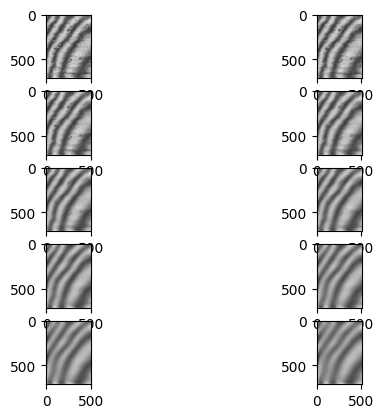

In [157]:
curr_img = copy.deepcopy(img)

angles = [0, -np.pi/4, np.pi/4, np.pi/2]
direct = DirectList(angles)

L = list(range(10,110,10))
M = list(range(5,27,2))

plt.figure()
i = 1

for l,m in zip(L,M):
    direct.img_to_directions(curr_img)

    disp = DispCoeffMulty(L=l,M=m)

    disp.line_list_dispertion(direct)
    disp.avg_line_list_dispertion()

    direct.process(L=l)
    direct.lines_to_img()

    curr_img = smooth_fringes(direct, disp)

    plt.subplot(5,2,i)
    plt.imshow(curr_img, cmap='gray', vmin=0, vmax=255)
    i += 1

plt.show()

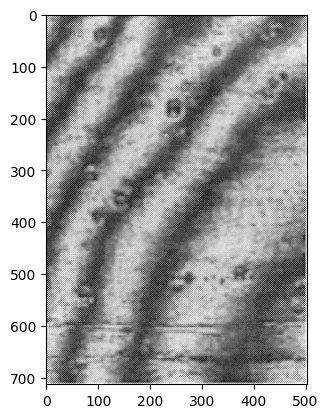

In [124]:
plt.figure()
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

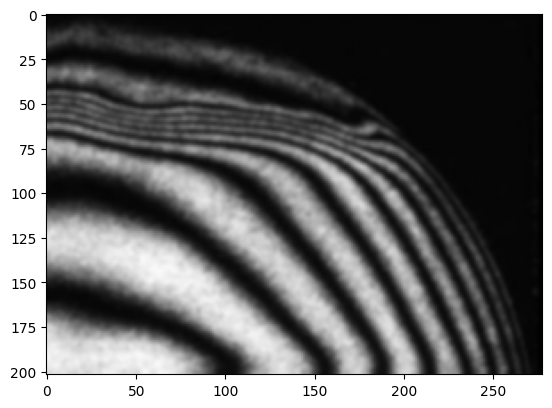

In [61]:
img_gauss = cv2.GaussianBlur(img, (5,5),0)

plt.figure()
plt.imshow(img_gauss, cmap='gray', vmin=0, vmax=255)
plt.show()

In [95]:
np.zeros((0,0))

array([], shape=(0, 0), dtype=float64)

In [6]:
a = list(range(10))
print(a)
for i, item in enumerate(a):
    a[i] = item**2
print(a)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [140]:
a = list(range(10,110,10))
b = list(range(5,27,2))

print(a, b, sep="\n")

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
